In [ ]:
keras.__version__

In [1]:
import os
import sys
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import json
base_dir = os.path.dirname(os.getcwd())
print(base_dir)
sys.path.insert(1, base_dir)
from package.api import DB as api
import package.utils as utils
import package.tuning as tuning
utils.check_gpu()

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from scipy.interpolate import interp1d

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers, optimizers, metrics
#import tensorflow_addons as tfa

import keras_tuner as kt

from keras import backend

from kerastuner_tensorboard_logger import (
    TensorBoardLogger,
    setup_tb  # Optional
)


%matplotlib inline
%load_ext autoreload
%autoreload 2


log_location = base_dir + '/logs'
model_location = base_dir + '/models'
data_location = base_dir + '/data'

paths_df = pd.read_csv(base_dir + '/paths.csv')
paths_df['path'] = base_dir + '/' + paths_df['path']

W_cols = ['Mach', 'alt', 'TRA', 'T2', 'time']
Xs_cols = ['Wf', 'Nf', 'Nc', 'T24', 'T30', 'T48', 'T50', 'P15', 'P2', 'P21', 'P24', 'Ps30', 'P40', 'P50']
aux_cols = ['cycle', 'hs', 'Fc', 'asset_id']

C:\Users\Marcos Quinones\phm2021_data_challenge


C:\Users\lab\envs\tfgpu\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


2.8.0
[INFO] GPU?: <True> [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
expanding memory growth


In [4]:
# Fc = 3
# dataset = 'DS08'

def get_data(Fc=None, dataset=None, downsample=20):

    data_header = f'Fc-{Fc}_dataset-{dataset}'

    params = {'datasource.username': 'macslab', # the username of the logged in user
                'datasource.password': 'Ch0colate!', 
                'datasource.database': 'ncmapss_db', # <- NO CHANGE 
                'datasource.url': '10.2.219.98', # <- or your database installation location
                'datasource.port': '5432'} # <- most likely don't change
    db, cur =  api.connect(params)
    db.set_session(autocommit=True)
    del(params)


    units_df = api._get_units(db=db)
    if Fc is not None and dataset is not None:
        print('here')
        if type(dataset) == type([]):
            dataset = '|'.join(dataset)
        units = units_df[(units_df['Fc'] == Fc) & (units_df['dataset'].str.contains(dataset))]
    elif Fc is not None:
        units = units_df[units_df['Fc'] == Fc]
    elif dataset is not None:
        if type(dataset) == type([]):
            dataset = '|'.join(dataset)
        units = units_df[units_df['dataset'].str.contains(dataset)]
    else:
        units = units_df


    tables = ['summary_tb', 'telemetry_tb']
    df = api._get_data(db=db,
                       units=pd.unique(units.id),
                       tables=tables,
                       downsample=downsample).astype(np.float32)
    utils.add_time_column(units=pd.unique(units.id), df=df)
    utils.add_rul_column(units=pd.unique(units.id), df=df)
    
    return units_df, units, df, data_header

def preprocess_data(df, scale_output=False):

    scaler = MinMaxScaler()
    model = keras.models.load_model(paths_df[paths_df['name']=='flight_effects_h5'].path.values[0])
    yscaler = joblib.load(paths_df[paths_df['name']=='flight_effects_yscaler'].path.values[0])
    xscaler = joblib.load(paths_df[paths_df['name']=='flight_effects_xscaler'].path.values[0])

    trace = yscaler.transform(df[Xs_cols])
    pred = model.predict(xscaler.transform(df[W_cols]))
    res = trace - pred
    dfx = pd.DataFrame(data=res, columns=Xs_cols)
    df_x = pd.DataFrame(data=xscaler.transform(df[W_cols]), columns=W_cols)
    dfx = pd.concat([dfx, df_x, df[aux_cols]], axis=1)
    if not scale_output:
        dfx['rul'] = df['rul'].values
    else:
        print('scaling output')
        #dfx['rul'] = scaler.fit_transform(df['rul'].values.reshape(-1,1))
        dfx['rul'] = df['rul']/100
    dfx.time = dfx.time + (dfx.cycle -1)
    
    return dfx, scaler
    

In [5]:
units_df, units, df, data_header = get_data()
dfx, _ = preprocess_data(df)

In [8]:
dummies = pd.get_dummies(dfx['Fc']).rename(columns=lambda x: f'Fc_{int(x)}')
dfx = pd.concat([dfx, dummies], axis=1)
dfx.drop(columns=['Fc'], inplace=True)

In [9]:
x_cols = Xs_cols + W_cols + ['Fc_1', 'Fc_2', 'Fc_3']

train_df, train_y, val_df, val_y, test_df, test_y = utils.train_test_split(df=dfx[dfx.hs == 0], 
                                                                           units=list(units.id.values), 
                                                                           y_labels=['rul'], 
                                                                           t_labels=aux_cols + x_cols, 
                                                                           train_pct = .8, val_pct=.1, test_pct=.1, verbose=True)

90
72
9
9
train, val, test set counts: 72, 9, 9
90 90
train units: [19, 85, 20, 14, 3, 67, 46, 87, 68, 60, 86, 63, 9, 57, 70, 17, 58, 34, 13, 51, 56, 43, 47, 18, 5, 39, 71, 41, 69, 24, 89, 53, 61, 75, 64, 49, 50, 55, 11, 37, 72, 16, 79, 88, 23, 1, 7, 33, 2, 21, 82, 74, 81, 10, 22, 31, 73, 76, 54, 6, 36, 42, 90, 84, 26, 66, 27, 59, 45, 28, 32, 44]
val units: [77, 38, 83, 48, 52, 30, 40, 35, 29]
test units: [62, 4, 15, 12, 65, 25, 78, 80, 8]


In [11]:

horizon = 1
n_out = 1
n_features = len(x_cols)

monitor = 'val_root_mean_squared_error'
mode = 'min'
min_delta = .1
patience = 10

batch_size = 32
epochs = 50

params = []

#params.append(tuning.MyParameters(layers=6, units=16, dropout_rate=.25, learning_rate = .001, recurrent_dropout=0.0, l1=.000001, l2=.00001))
params.append(tuning.MyParameters(layers=3, units=24, dropout_rate=.2, learning_rate = .00075, recurrent_dropout=0.0, l1=.000001, l2=.00001))
params.append(tuning.MyParameters(layers=3, units=32, dropout_rate=.2, learning_rate = .0005, recurrent_dropout=0.0, l1=.000001, l2=.00001))
params.append(tuning.MyParameters(layers=3, units=64, dropout_rate=.2, learning_rate = .00075, recurrent_dropout=0.0, l1=.000001, l2=.00001))

horizon = 1
num_outputs = 1
num_layers = 3
num_features = len(x_cols)

input_shape = (None, num_features)


def decay_schedule(epoch, lr):
    if epoch > 1 and epoch < 10:
        lr = lr * .99
    elif epoch >= 10 and epoch < 25:
        lr = lr * .98
    else:
        lr = lr * .97
            
    return lr

lr_scheduler = keras.callbacks.LearningRateScheduler(decay_schedule)

early_stopping = keras.callbacks.EarlyStopping(monitor=monitor,
                                               mode=mode,
                                               min_delta=min_delta,
                                               patience=patience,
                                               verbose=1,
                                               restore_best_weights=True)#True)

In [ ]:
min_seq_len = 200
max_seq_len = 2000

traces = []
preds = []
test_units = []

models = []
scores = []


results = {}
results['params'] = params[0].__dict__

lookback = 1200

my_tuning = tuning.Tuning(input_shape, n_out)

model = my_tuning.build_bilstm_model(params[0])

print("temporalizing test and val data")
X_test, y_test = utils.temporalize_data(test_df[x_cols].values, test_y, lookback, horizon, n_features, n_out)
X_val, y_val = utils.temporalize_data(val_df[x_cols].values, val_y, lookback, horizon, n_features, n_out)

X_test = np.array(X_test).astype(np.float32)
y_test = np.array(y_test).astype(np.float32)

X_val = np.array(X_val).astype(np.float32)
y_val = np.array(y_val).astype(np.float32)

returning model
temporalizing test and val data


returning model
-----------------  epoch 0  ---------------------------------------------
............  unit 67.0  ...... lookback 2358
755/755 [==============================] - 455s 594ms/step - loss: 1710.3723 - root_mean_squared_error: 10.2363
............  unit 71.0  ...... lookback 1043
921/921 [==============================] - 300s 323ms/step - loss: 1560.6912 - root_mean_squared_error: 9.7650
............  unit 77.0  ...... lookback 2099
882/882 [==============================] - 477s 537ms/step - loss: 1095.6478 - root_mean_squared_error: 8.1571
............  unit 78.0  ...... lookback 602
962/962 [==============================] - 225s 234ms/step - loss: 1232.3750 - root_mean_squared_error: 8.6678
............  unit 81.0  ...... lookback 1856
809/809 [==============================] - 394s 487ms/step - loss: 209.2491 - root_mean_squared_error: 3.4428
............  unit 83.0  ...... lookback 1800
795/795 [==============================] - 377s 475ms/step - loss: 122.8076 - ro

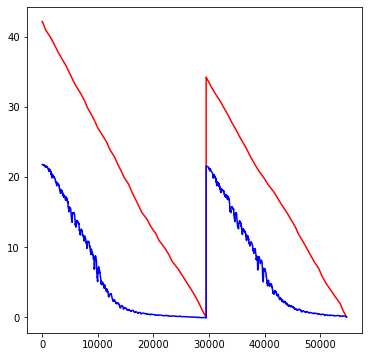

INFO:tensorflow:Assets written to: C:\Users\Marcos Quinones\phm2021_data_challenge/models/Fc-3_dataset-DS08/3-layers_24-units_00075_learningRate/model_var_0\assets


INFO:tensorflow:Assets written to: C:\Users\Marcos Quinones\phm2021_data_challenge/models/Fc-3_dataset-DS08/3-layers_24-units_00075_learningRate/model_var_0\assets


-----------------  epoch 1  ---------------------------------------------
............  unit 67.0  ...... lookback 2065
764/764 [==============================] - 407s 533ms/step - loss: 109.6551 - root_mean_squared_error: 2.3890
............  unit 71.0  ...... lookback 2144
886/886 [==============================] - 487s 549ms/step - loss: 172.7723 - root_mean_squared_error: 3.0971
............  unit 77.0  ...... lookback 2061
883/883 [==============================] - 470s 532ms/step - loss: 104.0060 - root_mean_squared_error: 2.3102
............  unit 78.0  ...... lookback 920
952/952 [==============================] - 288s 303ms/step - loss: 136.3554 - root_mean_squared_error: 2.7067
............  unit 81.0  ...... lookback 1106
833/833 [==============================] - 279s 334ms/step - loss: 66.2137 - root_mean_squared_error: 1.7357
............  unit 83.0  ...... lookback 1432
806/806 [==============================] - 323s 400ms/step - loss: 68.3426 - root_mean_squared_error: 

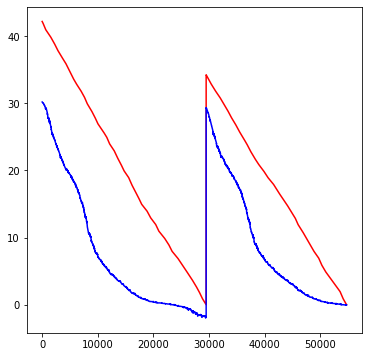

INFO:tensorflow:Assets written to: C:\Users\Marcos Quinones\phm2021_data_challenge/models/Fc-3_dataset-DS08/3-layers_24-units_00075_learningRate/model_var_1\assets


INFO:tensorflow:Assets written to: C:\Users\Marcos Quinones\phm2021_data_challenge/models/Fc-3_dataset-DS08/3-layers_24-units_00075_learningRate/model_var_1\assets


-----------------  epoch 2  ---------------------------------------------
............  unit 67.0  ...... lookback 1669
776/776 [==============================] - 348s 449ms/step - loss: 55.4873 - root_mean_squared_error: 1.5372
............  unit 71.0  ...... lookback 1065
920/920 [==============================] - 301s 327ms/step - loss: 114.5262 - root_mean_squared_error: 2.4500
............  unit 77.0  ...... lookback 1150
912/912 [==============================] - 314s 344ms/step - loss: 82.1706 - root_mean_squared_error: 1.9968
............  unit 78.0  ...... lookback 1873
922/922 [==============================] - 455s 493ms/step - loss: 85.6257 - root_mean_squared_error: 2.0514
............  unit 81.0  ...... lookback 1041
835/835 [==============================] - 268s 322ms/step - loss: 76.4531 - root_mean_squared_error: 1.9118
............  unit 83.0  ...... lookback 1917
791/791 [==============================] - 397s 501ms/step - loss: 57.2709 - root_mean_squared_error: 1.

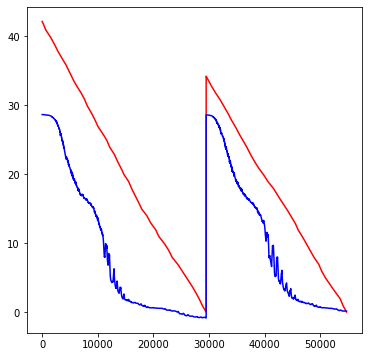

INFO:tensorflow:Assets written to: C:\Users\Marcos Quinones\phm2021_data_challenge/models/Fc-3_dataset-DS08/3-layers_24-units_00075_learningRate/model_var_2\assets


INFO:tensorflow:Assets written to: C:\Users\Marcos Quinones\phm2021_data_challenge/models/Fc-3_dataset-DS08/3-layers_24-units_00075_learningRate/model_var_2\assets


-----------------  epoch 3  ---------------------------------------------
............  unit 67.0  ...... lookback 933
799/799 [==============================] - 243s 304ms/step - loss: 65.4652 - root_mean_squared_error: 1.7258
............  unit 71.0  ...... lookback 1539
905/905 [==============================] - 381s 421ms/step - loss: 101.9718 - root_mean_squared_error: 2.2861
............  unit 77.0  ...... lookback 1478
901/901 [==============================] - 372s 413ms/step - loss: 75.8311 - root_mean_squared_error: 1.8970
............  unit 78.0  ...... lookback 1582
931/931 [==============================] - 402s 432ms/step - loss: 86.6062 - root_mean_squared_error: 2.0674
............  unit 81.0  ...... lookback 1939
807/807 [==============================] - 412s 510ms/step - loss: 53.7205 - root_mean_squared_error: 1.5012
............  unit 83.0  ...... lookback 653
831/831 [==============================] - 207s 249ms/step - loss: 59.7700 - root_mean_squared_error: 1.61

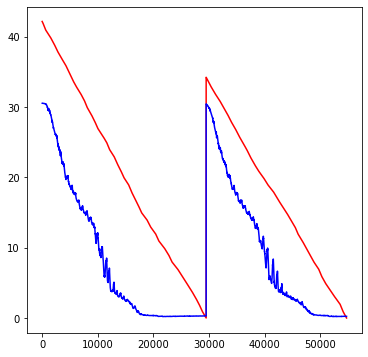

INFO:tensorflow:Assets written to: C:\Users\Marcos Quinones\phm2021_data_challenge/models/Fc-3_dataset-DS08/3-layers_24-units_00075_learningRate/model_var_3\assets


INFO:tensorflow:Assets written to: C:\Users\Marcos Quinones\phm2021_data_challenge/models/Fc-3_dataset-DS08/3-layers_24-units_00075_learningRate/model_var_3\assets


-----------------  epoch 4  ---------------------------------------------
............  unit 67.0  ...... lookback 1196
791/791 [==============================] - 283s 358ms/step - loss: 55.2895 - root_mean_squared_error: 1.5336
............  unit 71.0  ...... lookback 1616
903/903 [==============================] - 396s 439ms/step - loss: 96.3185 - root_mean_squared_error: 2.2081
............  unit 77.0  ...... lookback 693
926/926 [==============================] - 235s 254ms/step - loss: 72.5037 - root_mean_squared_error: 1.8436
............  unit 78.0  ...... lookback 1764
925/925 [==============================] - 435s 471ms/step - loss: 70.3103 - root_mean_squared_error: 1.8081
............  unit 81.0  ...... lookback 1548
819/819 [==============================] - 349s 427ms/step - loss: 52.9971 - root_mean_squared_error: 1.4871
............  unit 83.0  ...... lookback 1461
805/805 [==============================] - 332s 413ms/step - loss: 54.0373 - root_mean_squared_error: 1.50

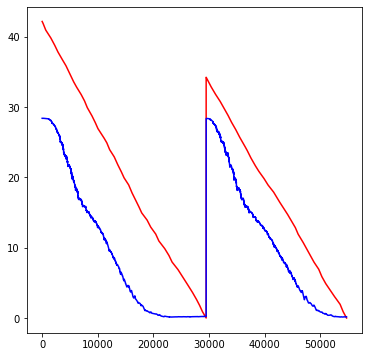

INFO:tensorflow:Assets written to: C:\Users\Marcos Quinones\phm2021_data_challenge/models/Fc-3_dataset-DS08/3-layers_24-units_00075_learningRate/model_var_4\assets


INFO:tensorflow:Assets written to: C:\Users\Marcos Quinones\phm2021_data_challenge/models/Fc-3_dataset-DS08/3-layers_24-units_00075_learningRate/model_var_4\assets


-----------------  epoch 5  ---------------------------------------------
............  unit 67.0  ...... lookback 673
807/807 [==============================] - 206s 255ms/step - loss: 61.3298 - root_mean_squared_error: 1.6513
............  unit 71.0  ...... lookback 2323
881/881 [==============================] - 521s 591ms/step - loss: 80.4062 - root_mean_squared_error: 1.9739
............  unit 77.0  ...... lookback 2307
875/875 [==============================] - 514s 587ms/step - loss: 62.1677 - root_mean_squared_error: 1.6640
............  unit 78.0  ...... lookback 1341
939/939 [==============================] - 361s 385ms/step - loss: 66.5820 - root_mean_squared_error: 1.7444
............  unit 81.0  ...... lookback 2228
798/798 [==============================] - 452s 567ms/step - loss: 48.3150 - root_mean_squared_error: 1.3875
............  unit 83.0  ...... lookback 898
823/823 [==============================] - 246s 299ms/step - loss: 55.2302 - root_mean_squared_error: 1.532

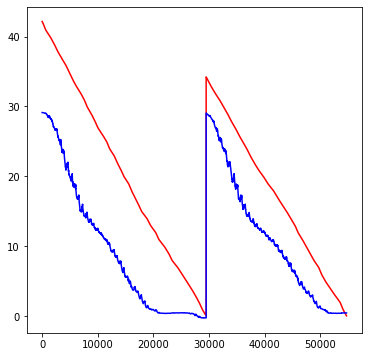

INFO:tensorflow:Assets written to: C:\Users\Marcos Quinones\phm2021_data_challenge/models/Fc-3_dataset-DS08/3-layers_24-units_00075_learningRate/model_var_5\assets


INFO:tensorflow:Assets written to: C:\Users\Marcos Quinones\phm2021_data_challenge/models/Fc-3_dataset-DS08/3-layers_24-units_00075_learningRate/model_var_5\assets


-----------------  epoch 6  ---------------------------------------------
............  unit 67.0  ...... lookback 2410
753/753 [==============================] - 457s 606ms/step - loss: 48.9813 - root_mean_squared_error: 1.4028
............  unit 71.0  ...... lookback 2051
889/889 [==============================] - 473s 532ms/step - loss: 92.7434 - root_mean_squared_error: 2.1587
............  unit 77.0  ...... lookback 1759
893/893 [==============================] - 423s 474ms/step - loss: 62.6154 - root_mean_squared_error: 1.6720
............  unit 78.0  ...... lookback 1511
933/933 [==============================] - 393s 422ms/step - loss: 62.7854 - root_mean_squared_error: 1.6760
............  unit 81.0  ...... lookback 1750
812/812 [==============================] - 383s 472ms/step - loss: 46.7521 - root_mean_squared_error: 1.3529
............  unit 83.0  ...... lookback 891
823/823 [==============================] - 243s 295ms/step - loss: 51.4467 - root_mean_squared_error: 1.45

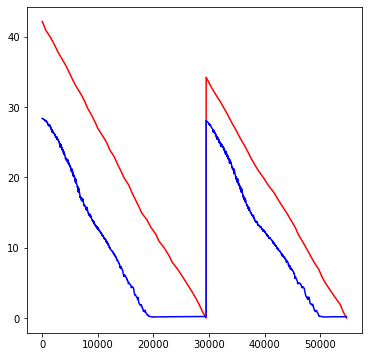

INFO:tensorflow:Assets written to: C:\Users\Marcos Quinones\phm2021_data_challenge/models/Fc-3_dataset-DS08/3-layers_24-units_00075_learningRate/model_var_6\assets


INFO:tensorflow:Assets written to: C:\Users\Marcos Quinones\phm2021_data_challenge/models/Fc-3_dataset-DS08/3-layers_24-units_00075_learningRate/model_var_6\assets


-----------------  epoch 7  ---------------------------------------------
............  unit 67.0  ...... lookback 857
802/802 [==============================] - 233s 290ms/step - loss: 56.9764 - root_mean_squared_error: 1.5684
............  unit 71.0  ...... lookback 736
930/930 [==============================] - 245s 263ms/step - loss: 107.5366 - root_mean_squared_error: 2.3613
............  unit 77.0  ...... lookback 1652
896/896 [==============================] - 402s 449ms/step - loss: 58.6439 - root_mean_squared_error: 1.5984
............  unit 78.0  ...... lookback 775
956/956 [==============================] - 259s 271ms/step - loss: 59.3434 - root_mean_squared_error: 1.6120
............  unit 81.0  ...... lookback 1273
827/827 [==============================] - 309s 374ms/step - loss: 46.3379 - root_mean_squared_error: 1.3439
............  unit 83.0  ...... lookback 1908
791/791 [==============================] - 398s 504ms/step - loss: 44.4352 - root_mean_squared_error: 1.300

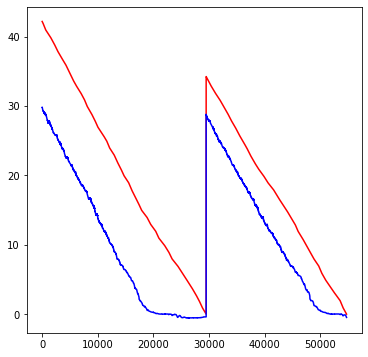

INFO:tensorflow:Assets written to: C:\Users\Marcos Quinones\phm2021_data_challenge/models/Fc-3_dataset-DS08/3-layers_24-units_00075_learningRate/model_var_7\assets


INFO:tensorflow:Assets written to: C:\Users\Marcos Quinones\phm2021_data_challenge/models/Fc-3_dataset-DS08/3-layers_24-units_00075_learningRate/model_var_7\assets


-----------------  epoch 8  ---------------------------------------------
............  unit 67.0  ...... lookback 880
801/801 [==============================] - 239s 298ms/step - loss: 47.4349 - root_mean_squared_error: 1.3690
............  unit 71.0  ...... lookback 1821
897/897 [==============================] - 433s 483ms/step - loss: 71.1661 - root_mean_squared_error: 1.8241
............  unit 77.0  ...... lookback 2238
878/878 [==============================] - 502s 572ms/step - loss: 57.9436 - root_mean_squared_error: 1.5853
............  unit 78.0  ...... lookback 2224
911/911 [==============================] - 516s 567ms/step - loss: 54.9886 - root_mean_squared_error: 1.5276
............  unit 81.0  ...... lookback 1519
820/820 [==============================] - 344s 420ms/step - loss: 43.8329 - root_mean_squared_error: 1.2858
............  unit 83.0  ...... lookback 1719
797/797 [==============================] - 368s 462ms/step - loss: 43.9333 - root_mean_squared_error: 1.28

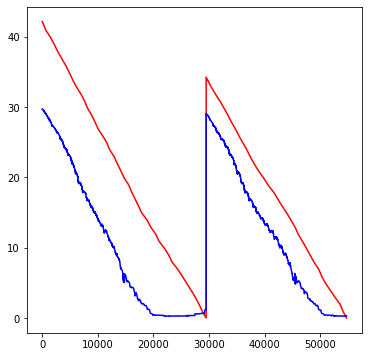

INFO:tensorflow:Assets written to: C:\Users\Marcos Quinones\phm2021_data_challenge/models/Fc-3_dataset-DS08/3-layers_24-units_00075_learningRate/model_var_8\assets


INFO:tensorflow:Assets written to: C:\Users\Marcos Quinones\phm2021_data_challenge/models/Fc-3_dataset-DS08/3-layers_24-units_00075_learningRate/model_var_8\assets


-----------------  epoch 9  ---------------------------------------------
............  unit 67.0  ...... lookback 2306
756/756 [==============================] - 443s 585ms/step - loss: 42.4898 - root_mean_squared_error: 1.2538
............  unit 71.0  ...... lookback 1712
900/900 [==============================] - 419s 465ms/step - loss: 88.7707 - root_mean_squared_error: 2.1021
............  unit 77.0  ...... lookback 1476
901/901 [==============================] - 373s 414ms/step - loss: 56.8776 - root_mean_squared_error: 1.5640
............  unit 78.0  ...... lookback 1641
929/929 [==============================] - 416s 448ms/step - loss: 55.6669 - root_mean_squared_error: 1.5406
............  unit 81.0  ...... lookback 2231
797/797 [==============================] - 454s 569ms/step - loss: 42.4158 - root_mean_squared_error: 1.2519
............  unit 83.0  ...... lookback 1887
792/792 [==============================] - 393s 497ms/step - loss: 45.6677 - root_mean_squared_error: 1.3

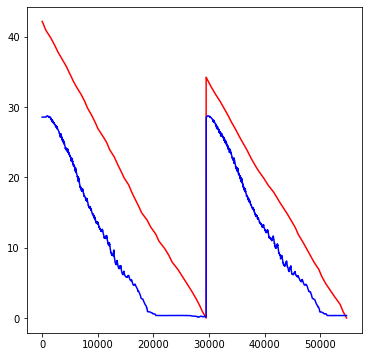

INFO:tensorflow:Assets written to: C:\Users\Marcos Quinones\phm2021_data_challenge/models/Fc-3_dataset-DS08/3-layers_24-units_00075_learningRate/model_var_9\assets


INFO:tensorflow:Assets written to: C:\Users\Marcos Quinones\phm2021_data_challenge/models/Fc-3_dataset-DS08/3-layers_24-units_00075_learningRate/model_var_9\assets


-----------------  epoch 10  ---------------------------------------------
............  unit 67.0  ...... lookback 684
807/807 [==============================] - 205s 254ms/step - loss: 52.9092 - root_mean_squared_error: 1.4872
............  unit 71.0  ...... lookback 1313
912/912 [==============================] - 344s 377ms/step - loss: 80.1175 - root_mean_squared_error: 1.9706
............  unit 77.0  ...... lookback 962
917/917 [==============================] - 283s 309ms/step - loss: 58.1718 - root_mean_squared_error: 1.5885
............  unit 78.0  ...... lookback 2364
907/907 [==============================] - 539s 594ms/step - loss: 52.5031 - root_mean_squared_error: 1.4764
............  unit 81.0  ...... lookback 727
844/844 [==============================] - 220s 260ms/step - loss: 45.4444 - root_mean_squared_error: 1.3234
............  unit 83.0  ...... lookback 1144
815/815 [==============================] - 281s 345ms/step - loss: 44.1911 - root_mean_squared_error: 1.294

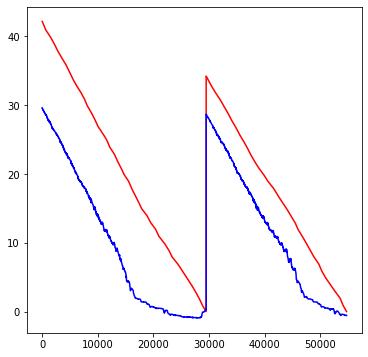

INFO:tensorflow:Assets written to: C:\Users\Marcos Quinones\phm2021_data_challenge/models/Fc-3_dataset-DS08/3-layers_24-units_00075_learningRate/model_var_10\assets


INFO:tensorflow:Assets written to: C:\Users\Marcos Quinones\phm2021_data_challenge/models/Fc-3_dataset-DS08/3-layers_24-units_00075_learningRate/model_var_10\assets


IndexError: single positional indexer is out-of-bounds

In [22]:
my_tuning = tuning.Tuning(input_shape, n_out)

model = my_tuning.build_bilstm_model(params[0])

best_score = 999999.9
count = 0
best_epoch = 0

for i in range(0,40):
    y_start = 0
    print(f"-----------------  epoch {i}  ---------------------------------------------")
    for unit in pd.unique(train_df.asset_id):
        
        X_train = train_df[train_df.asset_id == unit]
        X_train.reset_index(inplace=True, drop=True)

        y_end = X_train.shape[0] + y_start
        
        y_train = train_y[y_start:y_end].flatten()

        y_start = y_end
        
        lookback = np.random.randint(min_seq_len, max_seq_len)
        
        print(f"............  unit {unit}  ...... lookback {lookback}")
        
        X_train, y_train = utils.temporalize_data(X_train[x_cols].values, y_train, lookback, horizon, n_features, n_out)

        X_train = np.array(X_train).astype(np.float32)
        y_train = np.array(y_train).astype(np.float32)

        # tensorboard = keras.callbacks.TensorBoard(log_dir=f'{log_location}/kmeans/{data_header}/variable/train_unit_{unit}',
        #                               histogram_freq=1,
        #                               write_images=True,
        #                               write_graph=True)

        history = model.fit(X_train,
                            y_train,
                            batch_size=batch_size,
                            epochs=1,
                            shuffle=False,
                            validation_data=None,#(X_val, y_val),
                            #callbacks=[early_stopping, lr_scheduler, tensorboard],
                            verbose=1)

    test_score = model.evaluate(np.vstack([X_test, X_val]), np.vstack([y_test, y_val]), batch_size=batch_size)
    
    res = model.predict(np.vstack([X_test, X_val]))

    figure = plt.figure(figsize=(6,6))
    plt.plot(np.vstack([y_test, y_val]).flatten(), c='r')
    plt.plot(res.flatten(), c='b')
    plt.show()

    model.save(model_location + '/' + data_header + '/' + str(params[0]) + f'/model_var_{i}')
    model.save(model_location + '/' + data_header + '/' + str(params[0]) + f'/model_var_{i}.h5')

    traces.append(y_test.flatten())
    preds.append(res.flatten())

    variables = {"size_kb": os.path.getsize(model_location + '/' + data_header + '/' + str(params[0]) + f'/model_var_{i}.h5')/1024,
                     "val_rmse": 0,#history.history['val_root_mean_squared_error'][-1], 
                     "test_rmse": test_score[1], 
                     "test_unit": [int(x) for x in pd.unique(test_df.asset_id)], 
                     "val_unit": [int(x) for x in pd.unique(val_df.asset_id)],
                     "trace": [float(x) for x in list(traces[i])],
                     "pred": [float(x) for x in list(preds[i])]
                    }
    results[f'data_{i}'] = variables
    
    models.append(model)
    scores.append([(variables['val_rmse'] + variables['test_rmse']) / 2, variables['val_rmse'], variables['test_rmse']])

    if variables['test_rmse'] < best_score:
        best_score = variables['test_rmse']
        best_epoch = i
        count = 0
    else:
        count = count + 1
    
    if count == 10:
        break
    
with open(f'{log_location}/{data_header}_var.json', 'w') as outfile:
    json.dump(results, outfile)
    
print(f'best epoch: {best_epoch}')

In [ ]:
for fc in [3, 2, 1]:   
    units_df, units, df, data_header = get_data(fc, dataset)
    print(units.head())
    dfx, _ = preprocess_data(df, scale_output=False)
    #joblib.dump(rul_scaler, model_location + '/' + data_header + 'scaler.pkl')
    dfx0 = dfx[dfx.hs == 0]

    traces = []
    preds = []
    test_units = []
    
    models = []
    scores = []

    K = len(units)
    start = 0
    for j in range(0, len(params)):
        results = {}
        results = {}
        results['params'] = params[j].__dict__

        models.append([])
        scores.append([])

        for i in range(start, K):        
            test_df = dfx0[dfx0.asset_id == units.iloc[i].id]
            test_y = test_df.pop('rul')

            val_unit_id = units[(units.id != units.iloc[i].id) & (units.id != 71) & (units.id != 77) & (units.id != 78) & (units.id != 79)].sample(1).id.values[0]

            val_df = dfx0[dfx0.asset_id == val_unit_id]
            val_y = val_df.pop('rul')

            train_df = dfx0[(dfx0.asset_id != units.iloc[i].id) & (dfx0.asset_id != val_unit_id)]
            train_y = train_df.pop('rul')

            print("temporalizing")
            X_test, y_test = utils.temporalize_data(test_df[W_cols + Xs_cols].values, test_y.values, lookback, horizon, n_features, n_out)
            X_val, y_val = utils.temporalize_data(val_df[W_cols + Xs_cols].values, val_y.values, lookback, horizon, n_features, n_out)

            X_test = np.array(X_test).astype(np.float32)
            y_test = np.array(y_test).astype(np.float32)

            X_val = np.array(X_val).astype(np.float32)
            y_val = np.array(y_val).astype(np.float32)
                
            y_start = 0
            
            for unit in pd.unique(train_df.asset_id):
                y_end = X_train.shape[0] + y_start
                
                X_train = train_df[train_df.asset_id == unit]
                X_train = X_train[x_cols]
                X_train.reset_index(inplace=True, drop=True)

                y_end = X_train.shape[0] + y_start

                y_train = train_y[y_start:y_end].flatten()
                
                y_start = y_end
                
                X_train, y_train = utils.temporalize_data(X_train.values, y_train, lookback, horizon, n_features, n_out)
            
                X_train = np.array(X_train).astype(np.float32)
                y_train = np.array(y_train).astype(np.float32)

                my_tuning = tuning.Tuning(input_shape, n_out)

                model = my_tuning.build_bilstm_model(params[j])

                tensorboard = keras.callbacks.TensorBoard(log_dir=f'{log_location}/kmeans/{data_header}/model_{j}/test_unit_{units.iloc[i].id}/val_unit_{val_unit_id}',
                                              histogram_freq=1,
                                              write_images=True,
                                              write_graph=True)

                history = model.fit(X_train,
                                    y_train,
                                    batch_size=batch_size,
                                    epochs=epochs,
                                    shuffle=False,
                                    validation_data=(X_val, y_val),
                                    callbacks=[early_stopping, lr_scheduler, tensorboard],
                                    verbose=1)

                test_score = model.evaluate(X_test, y_test, batch_size=batch_size)

                res = model.predict(X_test)

                traces.append(y_test.flatten())
                preds.append(res.flatten())
                test_units.append(units.iloc[i].id)

                print(f'training on <{[int(x) for x in pd.unique(train_df.asset_id)]}>, validating on <{val_unit_id}>, testing on <{units.iloc[i].id}>')
                figure = plt.figure(figsize=(6,6))
                plt.plot(y_test.flatten(), c='r')
                plt.plot(res.flatten(), c='b')
                plt.show()

                model.save(model_location + '/' + data_header + '/' + str(params[j]) + f'/model_{i}')
                model.save(model_location + '/' + data_header + '/' + str(params[j]) + f'/model_{i}.h5')


                variables = {"size_kb": os.path.getsize(model_location + '/' + data_header + '/' + str(params[j]) + f'/model_{i}.h5')/1024,
                             "val_rmse": history.history['val_root_mean_squared_error'][-1], 
                             "test_rmse": test_score[1], 
                             "test_unit": int(test_units[i]), 
                             "val_unit": int(val_unit_id),
                             "trace": [float(x) for x in list(traces[i])],
                             "pred": [float(x) for x in list(preds[i])]
                            }

                results[f'data_{i}'] = variables

                models[j].append(model)
                scores[j].append([(variables['val_rmse'] + variables['test_rmse']) / 2, variables['val_rmse'], variables['test_rmse']])

        for attribute, value in results.items():
            if 'data' in str(attribute):
                print(results[attribute].keys())
                results[attribute]['pred'] = [float(x) for x in results[attribute]['pred']]
                results[attribute]['trace'] = [float(x) for x in results[attribute]['trace']]
                results[attribute]['test_unit'] = int(results[attribute]['test_unit'])
                results[attribute]['val_unit'] = int(results[attribute]['val_unit'])

        with open(f'{log_location}/{data_header}_{j}.json', 'w') as outfile:
            json.dump(results, outfile)

In [101]:
kfold_data = []
dataset='DS08'
for fc in range(1,4):
    data_header = f"Fc-{fc}_dataset-{dataset}"
    for j in range(3):
        print(f'{log_location}/{data_header}_{j}.json')
        with open(f'{log_location}/{data_header}_{j}.json', 'r') as f:
            kfold_data.append(json.loads(f.read()))

C:\Users\Marcos Quinones\phm2021_data_challenge/logs/Fc-1_dataset-DS08_0.json
C:\Users\Marcos Quinones\phm2021_data_challenge/logs/Fc-1_dataset-DS08_1.json
C:\Users\Marcos Quinones\phm2021_data_challenge/logs/Fc-1_dataset-DS08_2.json
C:\Users\Marcos Quinones\phm2021_data_challenge/logs/Fc-2_dataset-DS08_0.json
C:\Users\Marcos Quinones\phm2021_data_challenge/logs/Fc-2_dataset-DS08_1.json
C:\Users\Marcos Quinones\phm2021_data_challenge/logs/Fc-2_dataset-DS08_2.json
C:\Users\Marcos Quinones\phm2021_data_challenge/logs/Fc-3_dataset-DS08_0.json
C:\Users\Marcos Quinones\phm2021_data_challenge/logs/Fc-3_dataset-DS08_1.json
C:\Users\Marcos Quinones\phm2021_data_challenge/logs/Fc-3_dataset-DS08_2.json


In [100]:
#model_location + '/' + data_header + '/' + str(params[j])

In [ ]:
kfold_data = []
for i in range(3):
    with open(f'kfold_data_{i}.json', 'r') as f:
        kfold_data.append(json.loads(f.read()))

In [105]:
for i in range(len(kfold_data)):
    print(kfold_data[i].keys())

dict_keys(['params', 'data_0', 'data_1', 'data_2', 'data_3', 'data_4'])
dict_keys(['params', 'data_0', 'data_1', 'data_2', 'data_3', 'data_4'])
dict_keys(['params', 'data_0', 'data_1', 'data_2', 'data_3', 'data_4'])
dict_keys(['params', 'data_0', 'data_1', 'data_2', 'data_3', 'data_4', 'data_5', 'data_6', 'data_7', 'data_8', 'data_9'])
dict_keys(['params', 'data_0', 'data_1', 'data_2', 'data_3', 'data_4', 'data_5', 'data_6', 'data_7', 'data_8', 'data_9'])
dict_keys(['params', 'data_0', 'data_1', 'data_2', 'data_3', 'data_4', 'data_5', 'data_6', 'data_7', 'data_8', 'data_9'])
dict_keys(['params', 'data_0', 'data_1', 'data_2', 'data_3', 'data_4', 'data_5', 'data_6', 'data_7', 'data_8', 'data_9'])
dict_keys(['params', 'data_0', 'data_1', 'data_2', 'data_3', 'data_4', 'data_5', 'data_6', 'data_7', 'data_8', 'data_9'])
dict_keys(['params', 'data_0', 'data_1', 'data_2', 'data_3', 'data_4', 'data_5', 'data_6', 'data_7', 'data_8', 'data_9'])


In [ ]:
test_rmse_vals = np.zeros((10,3))
val_rmse_vals = np.zeros((10,3))
for i in range(3):
    print(f"model_{i}")
    for j in range(10):
        print(kfold_data[i][f'model_{i}'][f'data_{j}']['val_rmse'])
        val_rmse_vals[j,i] = kfold_data[i][f'model_{i}'][f'data_{j}']['val_rmse']
        test_rmse_vals[j,i] = kfold_data[i][f'model_{i}'][f'data_{j}']['test_rmse']

In [ ]:
test_rmse_df = pd.DataFrame(test_rmse_vals, columns=['m1', 'm2', 'm3'])

In [ ]:
test_rmse_df = test_rmse_df.drop([1,2,3,4])
test_rmse_df

In [ ]:
val_rmse_df = pd.DataFrame(val_rmse_vals, columns=['m1', 'm2', 'm3'])

In [ ]:
test_rmse_df

In [ ]:
sizes = np.array([24, 32, 64])
scores = np.array([np.mean(test_rmse_df['m1'].values), np.mean(test_rmse_df['m1'].values), np.mean(test_rmse_df['m3'].values)])
stds = np.array([np.std(test_rmse_df['m1'].values), np.std(test_rmse_df['m1'].values), np.std(test_rmse_df['m1'].values)])

results_df = pd.DataFrame(np.stack([sizes, scores, stds], axis=1), columns = ['size', 'mean', 'std'])

plt.figure(figsize=(12, 8))
sns.scatterplot(data=results_df, s=250, x='size', y='mean', hue='size', palette='Dark2', legend=False)
sns.scatterplot(x=results_df['size'], s=150, y=results_df['mean'] + results_df['std'], marker='^', hue=results_df['size'],
                palette='Dark2', legend=False)
sns.scatterplot(x=results_df['size'], s=150, y=results_df['mean'] - results_df['std'], marker='v', hue=results_df['size'],
                palette='Dark2', legend=False)

for i in range(len(results_df)):
        plt.plot([results_df['size'][i], results_df['size'][i]],
                 [results_df['mean'][i] - results_df['std'][i], results_df['mean'][i] + results_df['std'][i]], color='gray')
        
        
# sizes = np.array([24, 32, 64])
# scores = np.array([np.mean(val_rmse_df['m1'].values), np.mean(val_rmse_df['m1'].values), np.mean(val_rmse_df['m3'].values)])
# stds = np.array([np.std(val_rmse_df['m1'].values), np.std(val_rmse_df['m1'].values), np.std(val_rmse_df['m1'].values)])

# results_df = pd.DataFrame(np.stack([sizes, scores, stds], axis=1), columns = ['size', 'mean', 'std'])

# sns.scatterplot(data=results_df, s=250, x='size', y='mean', hue='size', palette='Dark2', legend=False)
# sns.scatterplot(x=results_df['size'], s=150, y=results_df['mean'] + results_df['std'], marker='^', hue=results_df['size'],
#                 palette='Dark2', legend=False)
# sns.scatterplot(x=results_df['size'], s=150, y=results_df['mean'] - results_df['std'], marker='v', hue=results_df['size'],
#                 palette='Dark2', legend=False)

# for i in range(len(results_df)):
#         plt.plot([results_df['size'][i], results_df['size'][i]],
#                  [results_df['mean'][i] - results_df['std'][i], results_df['mean'][i] + results_df['std'][i]], color='gray')
        
        
        
plt.title('kfold test scores for 3 models')
plt.show()

In [ ]:
units.id.values

In [ ]:
x = np.arange(0,10)

plt.figure(figsize=(12,8))
for i in range(10):
    plt.text(i-.5, .5, f'unit {units.id.values[i]}')
    for j in range(3):
        plt.scatter(x[i], test_rmse_vals[i,j], c='r')
        
    for j in range(3):
        plt.scatter(x[i], val_rmse_vals[i,j], c='g')
        
plt.title('test unit scores for 3 models')
plt.show()

In [ ]:
for i in range(3):
    print(f"model_{i}")
    for j in range(10):
        plt.figure(figsize=(6,6))
        plt.plot(kfold_data[i][f'model_{i}'][f'data_{j}']['pred'], c='r', label='pred')
        plt.plot(kfold_data[i][f'model_{i}'][f'data_{j}']['trace'], c='b', label='trace')
        plt.legend()
        plt.show()